# step 0: Load required libraries and dependencies 

In [ ]:
import polars as pl
import pandas as pd
from matplotlib import pyplot as plt 
import seaborn as sns
import pathlib
import glob
import datetime
import numpy as np
import random
import io

# Step 1: Load data and model forecasts

In [ ]:
# LOAD Forecasts for comparisons.
actuals_week = pl.from_pandas( pd.read_csv( "./california-cases-per-week.csv" ));
actuals_day = pl.from_pandas( pd.read_csv( "./california-cases-per-day.csv" , names=["date", "count"] ));
competitors = pl.from_pandas( pd.read_csv( "./forecasts_covid.csv"));
# Now pull in all the humpty forecasts
# (please note these can be generated using the script '10_build_humpty_baseline.sh' located in the directory 'published_results'
Hbaseline = "humpty_baseline"
Hbasefiles = glob.glob( Hbaseline + "/fore2*[0-9].csv" ) ;
humpty = { f[(f.find("fore")+4):f.find( ".csv" )]:pl.from_pandas( pd.read_csv( f ) ) for f in Hbasefiles }
Hbasefiles_cum = glob.glob( Hbaseline + "/fore2*[0-9]CUM.csv" ); 
humpty_cum = { f[(f.find("fore")+4):f.find("CUM.csv")]:pl.from_pandas( pd.read_csv( f )) for f in Hbasefiles_cum }
#x1 = pl.from_pandas( pd.read_csv( "../data/humpty_day_forecasts.csv" ));
actuals_day=actuals_day.with_columns(change=pl.col("count").diff())
#print( humpty_cum.keys() )
#print( humpty_cum['2021-08-01'] )


# Step 2: Code to create fair comparison for different forecast methods.  


To compare Humpty to the published forecasts of other methods/models, some accommodation to the particulars of each method is needed.  Since methods offer various number of predictions at various times (including a periodic) there is no fair method to compare all at once.
Rather we can perform a pairwise comparison of humpty vs each model since our humpty baseline (offering 28 days of prediction for each data point) is complete enough to match forecast predictions of any model's particular dates (so long as the dates are within the interval of collected data).

This is done as a pairwise runoff, that is humpty vs method-X basis where method-X ranges over the data set collected from (CITE )

In the comparison of humpty vs method-X we perform the following steps:
1) Create a comparable set of predictions matching method-X directly.
2) Calculate a _mse sequence_ for each method over the comparable prediction time points.
3) Calculate a total mse score over the comparable prediction time points


*Step 1, Comparable set of predictions:* For each date $d$ when method-X offers a forecast (future prediction) we record the date of forecast and the 'target-dates' $t_d = [ t_1, t_2, \cdots, t_k ]$ for which method-X furnishes predictions.  We label the dates for which method-X offers predictions as:  $D = [ d_{1}, d_{2}, \cdots, d_{M} ]$.  Note if multiple predictions are provided by method-X we filter the forecast (signal is {\it confirmed incidence num}, quantile is 0.5) as the most relevant forecast for comparison.


*Step 2, Calculate a  _mse sequence_:*
For each date $d \in D$, let target dates $t_d = [t_1, t_2, \cdots, t_k ]$ be the time points at which method-X furnishes predictions using only data up to date $d$.  We do likewise, using data up to and including date $d$ but no further, the humpty model (fitted to data historical to and including date $d$) is then used to predict {\it confirmed incidence num} at forward times $t_1, t_2, \cdots, t_k $ matching predictions of model-X.   We label the forecast counts of method-X as $V_{d,1}, V_{d,2}, \cdots, V_{d,k}$ and the forecast counts of Humpty as $W_{d,1}, W_{d,2}, \cdots, W_{d,k}$.  Since our data set of {\it confirmed incidence num} only includes data from 2020-01-22 up to 2023-03-09, we limit the comparisons to only include dates and target-dates within the the data collection interval $I = [\text{2020-01-22}, \text{2023-03-09}]$  We are able to derive Humpty forecasts for any $d \in I \cap D(X)$.  Further, we are able to compare Humpty forecasts with that of method-X so long as $\left( d \in I \cap D(X) \right) \wedge \left( \bigwedge_{ t_j \in t_d } t_j \in I \cap D(X) \right)$.

Letting $C_i$ be the confirmed incidence number for each $i \in I$ be actual counts from data, letting $T = D(X) \cup I$, we can calculate a {\it forecasting-MSE} function for both method-X and Humpty as follows:
$$
\text{MSE}_X : T \rightarrow {\Bbb R}: i \rightarrow \left( \sum_{j \in t_i} \sqrt{ ( C_j - V_{i,j} )^2 }  \right)
$$
while 
$$
\text{MSE}_{\text{h}} : T \rightarrow {\Bbb R} : i \rightarrow \left( \sum_{j \in t_i} \sqrt{ ( C_j - W_{i,j} )^2 }  \right)
$$
Both functions are defined for $i \in T = D(X) \cup I $, the plot of which indicates the forecast accuracy as a function of date.


*Step 3, Calculating and comparing total {\it mse scores}:*
Finally a view of all pairs method-X vs Humpty is provided by calculating the total forecast accuracy comparison point as:
$$( x, y ) \ \ \text{with} \ \ x = \sum_{i \in T} MSE_X( i ) \ \ \text{and} \ \, y = \sum_{i \in T} MSE_h( i )
$$
These points are plotted in log-log scale below in figure \ref{fig:humpvsothers}, Note that the line $x=y$ represents {\it equal quality outcomes} for overall forecast error.  Points while points $x>y$ represent an outcomes where the forecast quality (measured as sum MSE) of Humpty out performs that of method-X.




In [ ]:
week_forecasters=competitors.filter( (pl.col( "incidence_period" ) == "epiweek" )).filter( (pl.col("signal") == "confirmed_incidence_num" ));

In [ ]:
def standard_filter( df, forecaster, signal='confirmed_incidence_num', period='epiweek', quantile=0.5  ):
    return df.filter( pl.col( "forecaster" ) == forecaster )\
             .filter( pl.col( "signal" ) == signal )\
             .filter( pl.col( 'incidence_period' ) == period )\
             .filter( pl.col( "quantile" ) == quantile )
def retrieve_comp_req( df, forecaster, signal='confirmed_incidence_num', period='epiweek' ):
    T= standard_filter(df,forecaster, signal, period );
    return T.unique(subset=[ 'forecast_date' , 'target_end_date'], maintain_order=True)\
            .select( ['forecast_date', 'target_end_date' ])\
            .group_by( "forecast_date" )\
            .agg(pl.col("target_end_date"))\
            .sort( by="forecast_date")
def create_forecast_compare_req( forecaster="COVIDhub-ensemble", signal='confirmed_incidence_num' , period='epiweek' ):
    H=retrieve_comp_req( competitors, forecaster, signal, period );
    rv = [];
    #rv1 = H[:,0].to_list()
    #rv2 = H[:,2].to_list();
    rv = H.map_rows( lambda t:  ( t[0] , sorted( t[1] )) )
    return list(zip( rv[:,0], [x.to_list() for x in rv[:,1]]  )); 
    # used to create compute map files.
    # return H.map_rows( lambda t: t[0] + ":" + ",".join( sorted( t[1] )) + f":{period}")[:,0].to_list()

In [ ]:
G = create_forecast_compare_req( 'Microsoft-DeepSTIA' );
print(str(G[:5]).replace("),", "),\n") + "\n...\n" + str(G[-5:]).replace(")", "),\n") )

In [ ]:
rv = []; 
COMPS = []
for m in week_forecasters['forecaster'].unique().to_list():
    X = create_forecast_compare_req( m );
    a = len( X )
    b = sum( [ len(x[1]) for x in X ] )
    c = max( [ len(x[1]) for x in X ] )
    rv.append( (b,a,c, m ));
    if ( b > 80 ) :
        COMPS.append(m );
rv.sort();
rv.reverse();
for k in rv:
    print( f"{k[3]:<30}\t{k[0]}\t{k[1]}\t{k[2]}\t{'*' if k[3] in COMPS else ''}" )

In [ ]:
def build_common_frame( cmethod , log=None):
    if log == None:
        log = io.StringIO("")
    def simplify_fcast( df , value="value"):
        return df.select( value = pl.col( value), forecast_date = pl.col( "forecast_date"), target_end_date = pl.col( "target_end_date") , forecaster=pl.col(  "forecaster" ) ) 
    #F1 = simplify_fcast(standard_filter( humpty_hope, "HUMPTY-baseline" ));

    def build_humpty_fcast_atpoint(fdate , matching_targets ): 
        """ 
        reading from the link below it appears that the epiweek forecast will integrates the values over the epi-week
        https://github.com/reichlab/covid19-forecast-hub/blob/master/data-processed/README.md#What-is-a-forecast 
        """
        fdx  = humpty[fdate] ;
        fdx2 = humpty_cum[fdate] ;
        chunk  = pl.concat( [ fdx.filter( pl.col( 'forecast_date' ) == fdate ).filter( pl.col( "target_end_date" ) == g ) for g in matching_targets], how="vertical").sort( "target_end_date") 
        chunk2 = pl.concat( [fdx2.filter( pl.col( 'forecast_date' ) == fdate ).filter( pl.col( "target_end_date" ) == g ) for g in [ fdate ] + matching_targets], how="vertical").sort( "target_end_date")        
        chunk2 = chunk2.with_columns( change=pl.col( "value" ).diff() )
        chunk2 = pl.concat( [ chunk2.filter( pl.col( "target_end_date" ) == g ) for g in matching_targets ] , how = "vertical" ).sort( "target_end_date" )
        #chunk2 = chunk2.rename( {"value", "oldvalue"} ); #.rename( {"change", "value" })
        #print( ">>"  , chunk2  );
        #chunk2.with_columns( pl.cols().add( )  )
        return chunk2

    def verify_humpty_fcast_match( fdate, matching_targets ):
        cnt = 0; 
        try:
            fdx = humpty[fdate] ;
            chunk = pl.concat( [fdx.filter( pl.col( 'forecast_date' ) == fdate ).filter( pl.col( "target_end_date" ) == g ) for g in matching_targets], how="vertical").sort( "target_end_date") 
            cnt = chunk.select(pl.len()).item()
        except:
            ...
        return (cnt == len( matching_targets ))#et is the number of new daily h

    def build_humpty_matching( cmethod , log=None):
        status, comp = verify_humpty_matching( cmethod , log=log );
        if len(comp):
            return pl.concat( [ build_humpty_fcast_atpoint( fdate, targets ) for fdate, targets in comp ] , how="vertical" )
        else:
            return None;
    
    def verify_humpty_matching( cmethod , log =None ):
        comp = create_forecast_compare_req( forecaster=cmethod );
        rv_comp_map = [];
        rv = True;
        for fdate, targets in comp:
            if (len( targets ) != 4 ):
                note = f"problem at {fdate} {cmethod} forecast only includes {len(targets)} dates , so humpty is matching" 
                if log:
                    log.write( note + "\n" ) 
                rv = False
            if not verify_humpty_fcast_match( fdate, targets ) :
                note = f"problem with {fdate} {targets} humpty doesn't have coverage " 
                if log: 
                    log.write( note + "\n"  )
                rv = False;
            else:
                rv_comp_map.append( (fdate, targets ));
        return (rv, rv_comp_map )

    F2 = simplify_fcast(standard_filter( competitors, cmethod ));
    gocond, comp = verify_humpty_matching( cmethod , log = log );
    if (len(comp)):
        F1 = simplify_fcast(build_humpty_matching( cmethod , log = log ), value = "change" )
        CU = pl.concat( [F1, F2], how="vertical" ).sort("target_end_date" );
    else: 
        CU = F2


    return (CU, cmethod, create_forecast_compare_req( forecaster=cmethod ), log)

In [ ]:
print( " example:  create a comparison for forecasting " )
a,b,c,h = build_common_frame(  'Microsoft-DeepSTIA'  );
print ( a  )
h.seek(0)
print ( h.read() ) 


In [ ]:
def create_side_by_side( cmethod, debug=False ):
    CU, cmethod, comp_map, issues = build_common_frame( cmethod ); # creates a data frame with match up (as many as possible) 
    RU = list(CU.group_by(["forecast_date"] ));
    RU.sort();
    #print( " RU "*30 );
    #print( RU )
    ##
    ## Delphi for example makes a prediction on forecast date for target_end_date which is 5 days out, with 3 subsequent forecasts at week intervals from first forecast.

    def cmp_group( dx, actuals , comp_map ):
        CM = dict( comp_map );
        FD=dx[1]['forecast_date'].unique()[0]; 
        Methods = dx[1]['forecaster'].unique();
        RV = {};
        for e,k in enumerate( CM[FD]):
            # k is the date of forecast
            for m in Methods:
                if m not in RV:
                    RV[m]=[]
                g = dx[1].filter( (pl.col('forecaster') == m )).filter( (pl.col( "target_end_date" ) == k))
                dstep = g['target_end_date'][0]
                # need to sum actual change from dstep to k.
                
                actuals_count_base = actuals_day.filter( (pl.col( "date" ) == (dstep if e==0 else CM[FD][e-1] ))).select( pl.col("count"))[0,0]
                actuals_count_next = actuals_day.filter( (pl.col( "date" ) == (dstep if e==0 else CM[FD][e] ))).select( pl.col("count"))[0,0]                                    
                #actuals = actuals_day.filter((pl.col("date")==dstep)).select(pl.col("change"))[0,0]
                actuals = actuals_count_next - actuals_count_base;
                disp = (g['value'][0] - actuals );
                sdisp = pow( disp ,2);
                #print( f"@{FD} {m} forward:{k} or {dstep}, mse:{sdisp} " )
                RV[m].append( sdisp );
        for m in RV:
            RV[m] = pow( sum( RV[m]), 0.5);
        RV['date'] = FD;
        return RV
          
    DD =[ cmp_group( dx, actuals_day, comp_map ) for dx in RU if dx[1].shape[0] == 8 ]
    reform = {'date':[d['date'] for d in DD], 'humpty':[d['HUMPTY-baseline'] for d in DD], cmethod: [d[cmethod] for d in DD]}

    rf = pl.DataFrame( reform )
    #print( rf )
    return (rf, cmethod, DD, issues);

In [ ]:
create_side_by_side( "PR_UMD-CF_RepTiLe" )

In [ ]:
print( actuals_day.filter( pl.col( "date" ) > '2021-01-01' ).filter( pl.col( "date" ) < '2021-02-01' ) )
print( standard_filter(week_forecasters, forecaster="CovidAnalytics-DELPHI" ).filter( pl.col( "target_end_date" ) > '2021-01-01' ).filter( pl.col( "target_end_date" ) < '2021-02-01' ))

In [ ]:
def compare_plot( rf, FMETHOD , output=None): 
    x = rf.select("date" )[:,0].to_list(); #np.array([datetime.datetime(2013, 9, 28, i, 0) for i in range(24)])
    y = rf.select( "humpty" )[:,0].to_list(); #np.random.randint(100, size=x.shape)
    y2 = rf.select( FMETHOD )[:,0].to_list();#np.random.randint( 100, size=x.shape);
    plt.figure( figsize=(18,5))
    plt.xticks(rotation=45, ha='right')
    plt.plot(x, y, color='blue' , label='humpty')
    plt.plot(x, y2, color='orange' , label=FMETHOD)
    plt.legend();
    plt.title( "Forecast LSE" )
    if ( output == None ):
        plt.show()
    else:
        plt.savefig( output );
        plt.close()

In [ ]:
print( "example 2: Lets do a side by side for covidhum-ensemble, note issues with covidhub w/r/t expected 4 forecast points per date" )
rf, cm, DD, issues = create_side_by_side( "COVIDhub-ensemble" )
compare_plot( rf, "COVIDhub-ensemble" )
issues.seek(0)
print( "\n".join(issues.read().split("\n")) + "..." )
print( rf )


In [ ]:
#print( week_forecasters.filter( pl.col( "forecast_date" ) == "2020-07-05" ))

#print( x1.filter( pl.col( "forecast_date" ) == "2020-07-06" ))
#print( competitors.filter( pl.col( "forecast_date" ) == "2020-07-06" ))

# COMPARING CODE

In [ ]:
dump_comp_file = False;
FXS = week_forecasters['forecaster'].unique().to_list()
print( FXS )
print(COMPS)


In [ ]:
plt.close()
plt.style.use('ggplot') 
G1 = ["AMM-EpiInvert","BPagano-RtDriven","CEID-Walk","Covid19Sim-Simulator","CovidActNow-SEIR_CAN","CovidAnalytics-DELPHI","COVIDhub-4_week_ensemble","COVIDhub-baseline","COVIDhub_CDC-ensemble","COVIDhub-ensemble","COVIDhub-trained_ensemble","CU-select","DDS-NBDS","Google_Harvard-CPF","IEM_MED-CovidProject","IHME-CurveFit","IowaStateLW-STEM","IQVIA_ACOE-STAN","IUPUI-HkPrMobiDyR","JCB-PRM","JHUAPL-Bucky","JHUAPLTDWG-ICATTML","JHU_CSSE-DECOM","JHU_IDD-CovidSP","JHU_UNC_GAS-StatMechPool","Karlen-pypm","KITmetricslab-select_ensemble","LANL-GrowthRate","LNQ-ens1","LosAlamos_NAU-CModel_SDVaxVar","LUcompUncertLab-VAR_3streams","Microsoft-DeepSTIA","MIT-Cassandra","MIT_ISOLAT-Mixtures","MOBS-GLEAM_COVID","MUNI-ARIMA","OliverWyman-Navigator","OneQuietNight-ML","PR_UMD-CF_RepTiLe","RobertWalraven-ESG","SDSC_ISG-TrendModel","SigSci-TS","UChicagoCHATTOPADHYAY-UnIT","UCLA-SuEIR","UCSB-ACTS","UMich-RidgeTfReg","USACE-ERDC_SEIR","USC-SI_kJalpha","UVA-Ensemble"]
G2 = ["BPagano-RtDriven","CEID-Walk","CovidAnalytics-DELPHI","COVIDhub-4_week_ensemble","COVIDhub-baseline","COVIDhub_CDC-ensemble","COVIDhub-ensemble","COVIDhub-trained_ensemble","CU-select","IEM_MED-CovidProject","JHUAPL-Bucky","JHU_CSSE-DECOM","JHU_IDD-CovidSP","Karlen-pypm","KITmetricslab-select_ensemble","LANL-GrowthRate","Microsoft-DeepSTIA","MIT-Cassandra","MIT_ISOLAT-Mixtures","MUNI-ARIMA","RobertWalraven-ESG","UCLA-SuEIR","UMich-RidgeTfReg","USC-SI_kJalpha","UVA-Ensemble","BPagano-RtDriven","CEID-Walk","CovidAnalytics-DELPHI","COVIDhub-4_week_ensemble","COVIDhub-baseline","COVIDhub_CDC-ensemble","COVIDhub-ensemble","COVIDhub-trained_ensemble","CU-select","IEM_MED-CovidProject","JHUAPL-Bucky","JHU_CSSE-DECOM","JHU_IDD-CovidSP","Karlen-pypm","KITmetricslab-select_ensemble","LANL-GrowthRate","Microsoft-DeepSTIA","MIT-Cassandra","MIT_ISOLAT-Mixtures","MUNI-ARIMA","RobertWalraven-ESG","UCLA-SuEIR","UMich-RidgeTfReg","USC-SI_kJalpha","UVA-Ensemble"]
G3 = G1 ; # FXS
G4 = COMPS;
TAB = [];
IMAGES=True;
for g in G4:
    output = f"humpty_vs_{g}.png" 
    output_log = f"humpty_vsw_{g}log.txt"
    print( f" {g} -> {output}" );
    rf,cmethod, DD, issues = create_side_by_side( g );
    issues.seek(0);
    if IMAGES:
        compare_plot( rf, cmethod, output=output ) 
    try:
        MSETHUMP = rf.select(pl.sum( "humpty" ));
        MSETCOMP = rf.select( pl.sum( cmethod ));
        TAB.append( (MSETHUMP[0,0], MSETCOMP[0,0], f"{cmethod} " ))
    except:
        print( f"{cmethod} has no comparison for humpty: its MSE is {MSETCOMP}" );


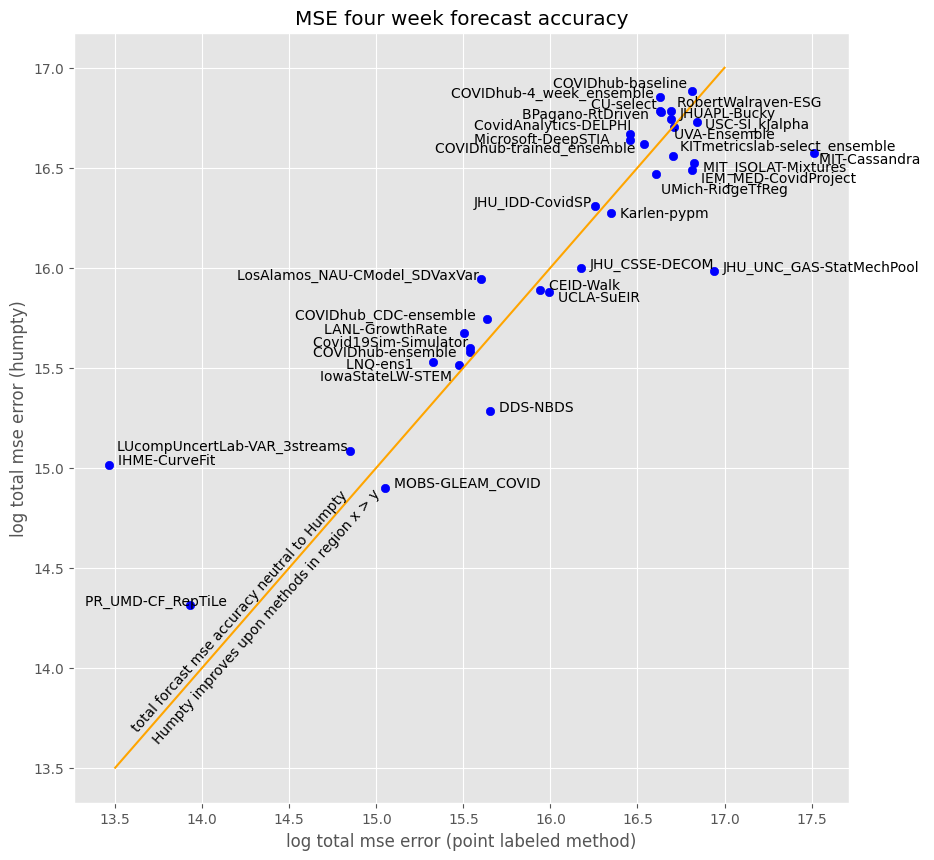

In [283]:
import math 
x = [math.log( t[1] ) for t in TAB]
y = [math.log( t[0] ) for t in TAB]
l = [t[2] for t in TAB]
plt.figure( figsize=(10,10))
plt.scatter( x, y,  color="blue" )
plt.plot( [13.5, 17.], [13.5, 17.], "orange")
plt.annotate( "total forecast mse accuracy neutral to Humpty" , (13.50 +0.2 - 0.12, 13.50 + 0.02 + 0.16 ), rotation=48.5 )
plt.annotate( "Humpty improves upon methods in region x > y " , (13.50 + 0.2 , 13.50 -0.04 + 0.16 ), rotation=48.5 )
for i, txt in enumerate(l):
    b1 = 0.0
    b0 = 0.0
    adjust = { "LosAlamos":(-1.4,0), "STEM":(0,0), "Simulator":(-0.9,0.01),  "LNQ":(-0.5,-0.03), "UMich":(0.03, -0.10),
              "LANL":(-0.8,0), "UCLA":(0.05,-0.05), "4_week":(-1.2,0), "ESG" :(0.0,0.0), "CEID":(0.05,0),
                "Bucky":(0.05,0.01), "Microsoft":(-0.9,-0.02), "IDD":(0,0), "COVIDhub-baseline":(-.8,0.02),
                "MED":(0,-.04),"ISOLAT":(0,0), "Cassandra":(0,0), "KITmetrics":(0,0), "CDC-ensemble":(-1.1,0 ),
                "DELPH":(-.9,0.02), "UVA":(0,-0.06), "COVIDhub-trained":(-1.2,-0.04), "USC":(0,0), "COVIDhub-ensemble":(-0.9,-0.025),
                "Driven":(0,0), "CU-select":(-0.4,0.01),  "PR_UMD":(-.6,0), "LUcomp" :(-1.34,0), "Iowa":(-0.8,-0.08),
                 "Karlen":(0.05, -0.02), "MED":(0.05, -0.06), "ISOLAT":(0.05,-0.04), "MOBS":(0.05,0), "DDS":(0.05,0), 
                "JHU_UNC":(0.05,0),"HME":(0.05,0), "JHU_CSS":(0.05,0), "IDD": (-0.7,0), "Driven":(-0.8,-0.03), 
                "USC":(0.05,-0.03),"raven":(0.03,0.02), "KIT":(0.04,0.03), "Cass":(0.03, -0.05)}
    arg = 0;
    for k in adjust: 
        if k in txt:
            b0, b1 = adjust[k]
    plt.annotate(txt, (x[i] + b0, y[i] + b1), rotation=arg )
#plt.scatter(x, y, s=area2, marker='o', c=c)
# Show the boundary between the regions:
#theta = np.arange(0, np.pi / 2, 0.01)
#plt.plot(r0 * np.cos(theta), r0 * np.sin(theta))
plt.xlabel( "log total mse error (point labeled method)" )
plt.ylabel( "log total mse error (humpty)" )
plt.title( "MSE four week forecast accuracy" )
plt.savefig( "Humpty_vs_comps.png" )

#plt.show()

In [ ]:
FXS = week_forecasters['forecaster'].unique().to_list()
FXS.sort()
all_dates = competitors.filter( pl.col( "incidence_period") == "epiweek").select( pl.col( "forecast_date" )).unique().sort(by="forecast_date")[:,0].to_list();                     
all_dates = week_forecasters.filter( pl.col( "incidence_period") == "epiweek").select( pl.col( "forecast_date" )).unique().sort(by="forecast_date")[:,0].to_list();                     

plt.figure( figsize=(64,5) );
c = 0; 
plt.plot( all_dates, [ 0 for g in all_dates ] , "." ,  color='k'); 
for mods in FXS:
    temp = standard_filter( week_forecasters , mods )
    d2 = temp.select( pl.col( "forecast_date" )).unique().sort(by="forecast_date")[:,0].to_list() ;
    plt.plot( [d for d in d2] , [ 1000.0 - (20*c/1.0) for d in d2 ], "x", label=mods );
    plt.annotate( f"{mods}" , ("2020-04-06" if (c %2 == 0 ) else "2020-07-17", 1000.0 - (20*c) ), size=10) #, rotation=0,0 )
    c += 1;    
#.filter( pl.col( "incidence_period" ) == "epiweek").filter( pl.col( "signal" ) == select( "forecaster) 
#plt.plot( all_dates , label="all")
#plt.plot( all_dates, [ 1.0 if d in dates_for_delphi else 0.0 for d in all_dates ] , 'bo', label="delphi");
#plt.plot(  all_dates, [ 0.9 if d in dates_for_arima else 0.0 for d in all_dates ], 'r+', label ="arima" );
plt.xticks( rotation=90 , ha="right")
plt.title( "method coverage" )
plt.legend()
plt.show()

In [ ]:
for m in FXS: 
     color='k'

In [ ]:
print( competitors.columns )
print( competitors.select('incidence_period').unique(  ))
print( competitors.select('signal').unique())